Trial 1 Complete [00h 09m 09s]
val_accuracy: 0.7772727012634277

Best val_accuracy So Far: 0.7772727012634277
Total elapsed time: 00h 09m 09s
Epoch 1/3
208/208 ━━━━━━━━━━━━━━━━━━━━ 185s 861ms/step - accuracy: 0.4865 - loss: 1.5881 - val_accuracy: 0.7341 - val_loss: 0.8536
Epoch 2/3
208/208 ━━━━━━━━━━━━━━━━━━━━ 177s 853ms/step - accuracy: 0.8008 - loss: 0.6580 - val_accuracy: 0.7568 - val_loss: 0.7684
Epoch 3/3
208/208 ━━━━━━━━━━━━━━━━━━━━ 181s 872ms/step - accuracy: 0.8648 - loss: 0.4758 - val_accuracy: 0.7727 - val_loss: 0.7278
best parameters:
 {'best_lr': 0.001, 'best_dropout': 0.2, 'best_batch_size': 32}
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 813ms/step - accuracy: 0.7300 - loss: 0.7039


Test Accuracy: 0.7545


test_loss: 0.7069500088691711, test_acc: 0.7545454502105713

--------------- Model Evaluation Metrics ---------------

14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 940ms/step
Classification Report:


,precision,recall,f1-score,support
adult rice weevil,0.057143,0.050000,0.053333,40.000000
american house spider,0.028571,0.025000,0.026667,40.000000
bedbug,0.096774,0.075000,0.084507,40.000000
brown stink bug,0.081081,0.075000,0.077922,40.000000
carpenter ant,0.147059,0.125000,0.135135,40.000000
cellar spider,0.081081,0.075000,0.077922,40.000000
flea,0.014706,0.025000,0.018519,40.000000
house centipede,0.057143,0.050000,0.053333,40.000000
silverfish,0.054054,0.050000,0.051948,40.000000
subterranean termite,0.093023,0.100000,0.096386,40.000000


<Figure size 800x600 with 0 Axes>

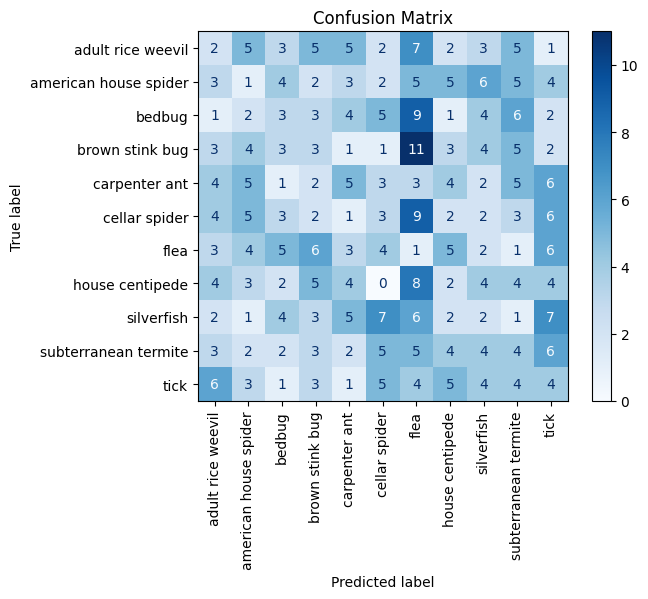

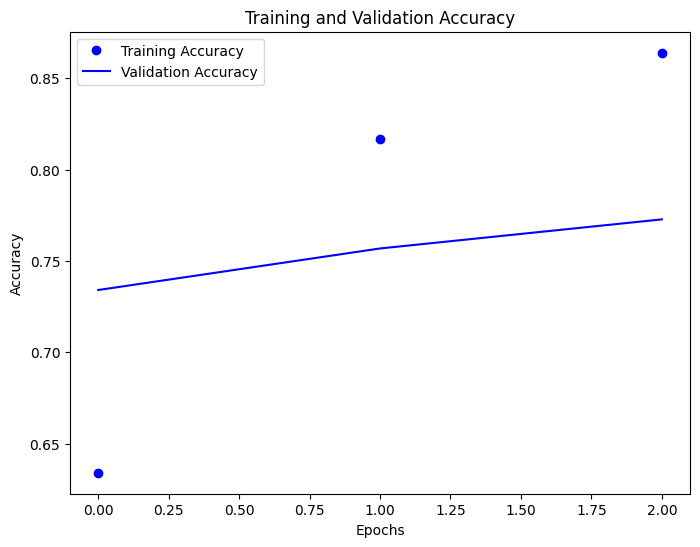

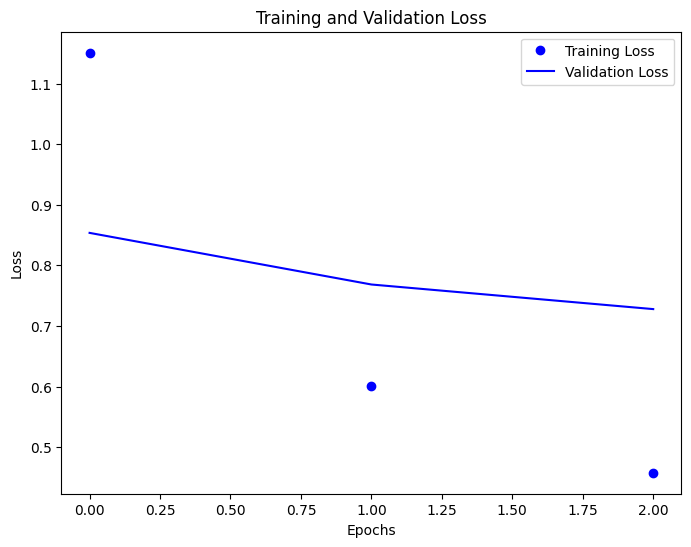

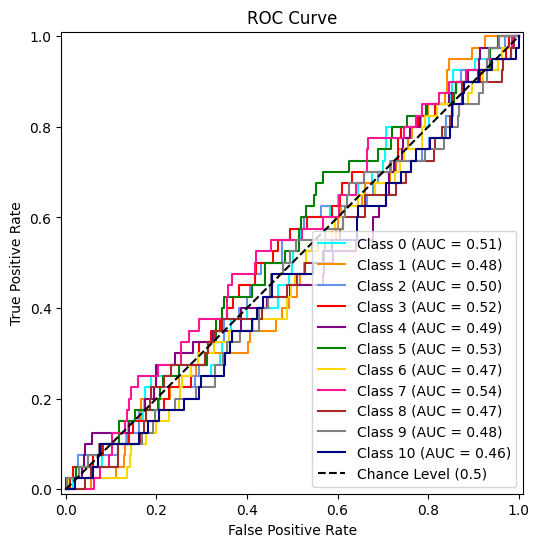

Macro-averaged One-vs-Rest ROC AUC score: 0.50
Accuracy: 0.068
Precision: 0.072
Recall: 0.068
F1 Score: 0.07


In [2]:
# Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, EfficientNetB0, VGG16, DenseNet201
from tensorflow.keras.models import Model
import os
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from IPython.display import display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from itertools import cycle
from sklearn.metrics import roc_curve, auc, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import label_binarize


import keras_tuner as kt
from tensorflow.keras.optimizers import Adam
from keras_tuner import HyperParameters 
# ----------- CONSTANTS ----------------

# define directory structure
TRAIN_DIR = "PROCESSED_DATA/TRAINING_DATA/TRAINING_AUGMENTED_DATA"
VALID_DIR = "PROCESSED_DATA/VALIDATION_DATA/"
TEST_DIR = "PROCESSED_DATA/TEST_DATA/"

# Image Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NORMALIZE_FLAG = True
NO_FRILLS_DATAGEN = ImageDataGenerator()
NORM_DATAGEN = ImageDataGenerator(rescale=1./255)


def load_data(directory,shuffle_flag=True):
    '''
    Param: 
        - directory - str, 
        - shuffle_flag - boolean, introduces constrolled stochasticity
    '''
    if NORMALIZE_FLAG == True:
        generator = NORM_DATAGEN.flow_from_directory(
        directory,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',shuffle=shuffle_flag)
        return generator
    else:
        generator = NO_FRILLS_DATAGEN.flow_from_directory(
        directory,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',shuffle=shuffle_flag)
        return generator

TRAIN_GENERATOR = load_data(TRAIN_DIR)
VAL_GENERATOR = load_data(VALID_DIR)
TEST_GENERATOR = load_data(TEST_DIR,shuffle_flag=False)
hp = HyperParameters()

def build_transfer_learning(hp):
    '''
    builds a transfer learning model using denseNet201 with classification layers
    specified in the JutePestDetect paper: https://arxiv.org/pdf/2308.05179 
    
    classification portion includes:
    -global average pooling layer
    -instead of 30% dropout layer, using tunable dropout
    -dense layer w softmax classifier
    '''
    base_model = DenseNet201(weights='imagenet', include_top=False,input_shape=(224, 224, 3))
    
    # freeze the base model layers
    base_model.trainable = False
    
    dropout_rate = hp.Float("dropout", min_value=0.2, max_value=0.5, step=0.1)
    
    # add global average pooling
    x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    x = Dropout(dropout_rate)(x)

    # dense layer w softmax classifier
    output_layer = Dense(TRAIN_GENERATOR.num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output_layer)
    
    # tune
    learning_rate = hp.Choice('lr', values=[1e-2, 1e-3, 1e-4])
    batch_size = hp.Choice('batch_size', values=[16, 32])
    optimizer = Adam(learning_rate=learning_rate)
    
    # tune learning rate, batch size
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    

    return model

def build_best_model_transfer_learning():

    # Define the Bayesian tuner
    tuner = kt.BayesianOptimization(
        build_transfer_learning,
        objective='val_accuracy',  # tune by improving validation accuracy
        max_trials=1,  # CHANGED for testing eval metrics, switch back to 20
        executions_per_trial=1,  # run each model once
        directory='bayesian_tuning',
        project_name='lr_and_drop_tuning_DenseNet201'
    )
    
    # search hp combos
    tuner.search(TRAIN_GENERATOR, validation_data=VAL_GENERATOR, epochs=3) # CHANGED for testing eval metrics, switch back to 10
    # get best hps
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    
    # save them
    best_hps_dict = {'best_lr': best_hps.get('lr'),
                     'best_dropout': best_hps.get('dropout'),
                     'best_batch_size': best_hps.get('batch_size')}
    
    # make final model with the best drop out, learning rate and batch size
    best_model = tuner.hypermodel.build(best_hps)
    best_model_training_history = best_model.fit(TRAIN_GENERATOR, validation_data=VAL_GENERATOR, 
                                                 epochs=3, # CHANGED for testing eval metrics, switch back to 10
                                                 batch_size=best_hps.get('batch_size'))
    
    return best_hps_dict, best_model, best_model_training_history


def evaluate_model(model, filename = "best_model_densenet201.h5"):
    '''
    Saves model to h5 file, returns test accuracy loss and test accuracy
    '''
    # evaluate on test data
    test_loss, test_acc = model.evaluate(TEST_GENERATOR)
    print(f"Test Accuracy: {test_acc:.4f}")
    
    # save to file
    model.save(filename)

    return test_loss, test_acc


# MODEL EVALUATION Functions ------

def create_classification_report(y_true, y_pred, class_indices):
    '''
    Params:
        y_true: true class labels
        y_pred: predicted class labels
        class_indices: mapping of class labels to class names.

    Function:
        generates a classification report including precision, recall, F1-score, and accuracy for each class
        outputs the report as a DataFrame for further analysis

    Returns:
        classification report as a dataframe
    '''
    report = classification_report(y_true, y_pred, target_names=list(class_indices.keys()), output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    print("Classification Report:")
    display(report_df)
    return report_df

    
def plot_confusion_matrix(y_true, y_pred, class_indices):
    '''
    Params:
        y_true: true class labels
        y_pred: predicted class labels
        class_indices: Mapping of class labels to class names

    Function:
        Plots a confusion matrix

    '''
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(class_indices.keys()))
    disp.plot(cmap=plt.cm.Blues, colorbar=True)
    plt.xticks(rotation=90)
    plt.title('Confusion Matrix')
    plt.show()


def plot_loss_curves(training_history):
    '''
    Params:
        training_history: object from model.fit() training history containing metrics accuracy and loss

    Function:
        plots training and validation accuracy and loss curves to evaluate model performance over epochs

    '''
    accuracy = training_history.history.get('accuracy', [])
    val_accuracy = training_history.history.get('val_accuracy', [])
    loss = training_history.history.get('loss', [])
    val_loss = training_history.history.get('val_loss', [])
    epochs = range(len(accuracy))

    # Plot training validation accuracy curve
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Plot training validation loss curve
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def plot_roc_curve(y_true, y_pred_probs, class_indices):
    '''
    Params:
        y_true: true class labels
        y_pred_probs: predicted probabilities for each class
        class_indices: mapping of class labels to class names

    Function:
        plots the receiver operating characteristic (ROC) curve for each class and calculates the macro-averaged
        one vs rest (OvR) ROC AUC score

    Returns:
        macro averaged one vs rest ROC AUC score
    '''

    # ROC AUC reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
    # ROC curve and AUC for multi-class classification
    y_true_bin = label_binarize(y_true, classes=list(range(len(class_indices))))
    n_classes = y_true_bin.shape[1]

    fig, ax = plt.subplots(figsize=(8, 6))
    colors = cycle(["aqua", "darkorange", "cornflowerblue", "red", "purple", "green", "gold", "deeppink", "brown", "gray", "navy"])

    for i, color in zip(range(n_classes), colors):
        RocCurveDisplay.from_predictions(
            y_true_bin[:, i],
            y_pred_probs[:, i],
            name=f"Class {i}",
            color=color,
            ax=ax
        )

    # Macro average OvR score reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
    # Macro average ROC AUC score using OvR strategy
    macro_roc_auc_ovr = roc_auc_score(y_true, 
                                      y_pred_probs, 
                                      multi_class="ovr", 
                                      average="macro")
    
    # ROC AUC plot reference: https://scikit-learn.org/1.1/auto_examples/model_selection/plot_roc.html
    # Plot ROC AUC curve
    ax.plot([0, 1], [0, 1], "k--", label="Chance Level (0.5)")
    ax.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title="ROC Curve",
    )
    ax.legend(loc="lower right")
    plt.show()
    print(f"Macro-averaged One-vs-Rest ROC AUC score: {macro_roc_auc_ovr:.2f}")
    return macro_roc_auc_ovr

    
def evaluation_metrics(model, generator, training_history):
    '''
    Params:
        model: trained model
        generator: data generator for the evaluation set
        training_history: object from model.fit() training history containing metrics accuracy and loss

    Function:
        combines evaluation metrics (classification report, confusion matrix, training curves, and ROC curve)
        outputs key metrics: accuracy, precision, recall, and F1-score

    Returns: 
        dictionary containing:
            accuracy: model accuracy on the evaluation data
            precision: macro averaged precision score
            recall: macro averaged recall score
            f1_score: macro averaged F1 score
            classification_report_df: classification report as a dataframe

    Outputs:
        confusion matrix plot
        loss plots
        ROC curve plot
        one vs rest ROC AUC score
    '''
    
    y_true = generator.classes
    y_pred_probs = model.predict(generator)
    y_pred = np.argmax(y_pred_probs, axis=1)
    class_indices = generator.class_indices

    # Classification report
    report_df = create_classification_report(y_true, y_pred, class_indices)

    # Confusion matrix
    plot_confusion_matrix(y_true, y_pred, class_indices)
    
    # Loss curves
    plot_loss_curves(training_history)

    # Macro average ROC AUC score
    macro_roc_auc_ovr = plot_roc_curve(y_true, y_pred_probs, class_indices)

    # Get key metrics
    accuracy = round(report_df.loc["accuracy", "precision"], 3)
    precision = round(report_df.loc["macro avg", "precision"], 3)
    recall = round(report_df.loc["macro avg", "recall"], 3)
    f1_score = round(report_df.loc["macro avg", "f1-score"], 3)

    # Print key metrics
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1_score}")

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score,
        "classification_report_df": report_df
    }


def main():
    # best model
    best_hps_dict, best_model, best_model_training_history = build_best_model_transfer_learning()
    
    print(f'best parameters:\n {best_hps_dict}')
    
    test_loss, test_acc = evaluate_model(best_model)
    print(f'test_loss: {test_loss}, test_acc: {test_acc}')
    
    best_model.save("test_densenet201_best_model_bayes_optimization.h5")
    
    # evaluation metrics on validation set
    print("\n--------------- Model Evaluation Metrics ---------------\n")
    densenet_model_metrics = evaluation_metrics(best_model, VAL_GENERATOR, # validation set
                                                best_model_training_history)
    
if __name__ == "__main__":
    main()
